# Samples counts by Province over time

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.{sample}_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, {sample}_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, '{sample}' AS sample_type
FROM 
    sample_{sample} ss
JOIN 
    complete_samples cs ON ss.id = cs.{sample}_sample_id
GROUP BY ss.id
)

SELECT 
    ap.name AS province,
    ad.name AS district,
    strftime('%Y-%m', s.date_of_collection) AS month,
    COUNT(*) AS total_samples
FROM (
    SELECT date_of_collection, site_id FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    ap.name, month
ORDER BY 
    ap.name, month;
"""

df = pd.read_sql(query, conn)
conn.close()


In [ ]:
df

In [52]:
# sort df by month
df['month'] = pd.to_datetime(df['month'])

# Define a complete date range from the start to end of the data
date_range = pd.date_range(start=df['month'].min(), end=df['month'].max(), freq='MS')

# Create a DataFrame for each province with all months in the date range
complete_df = pd.DataFrame()
for province in df['province'].unique():
    temp_df = pd.DataFrame(date_range, columns=['month'])
    temp_df['province'] = province
    complete_df = pd.concat([complete_df, temp_df])

# Merge the complete date range DataFrame with the original data
df_complete = pd.merge(complete_df, df, on=['province', 'month'], how='left')

# Fill missing values with 0
df_complete['total_samples'].fillna(0, inplace=True)
df_complete

,month,province,district,total_samples
0,2023-02-01,Karnali Pradesh,NaN,0.0
1,2023-03-01,Karnali Pradesh,NaN,0.0
2,2023-04-01,Karnali Pradesh,NaN,0.0
3,2023-05-01,Karnali Pradesh,NaN,0.0
4,2023-06-01,Karnali Pradesh,NaN,0.0
...,...,...,...,...
87,2024-08-01,Sudurpashchim Pradesh,NaN,0.0
88,2024-09-01,Sudurpashchim Pradesh,NaN,0.0
89,2024-10-01,Sudurpashchim Pradesh,NaN,0.0
90,2024-11-01,Sudurpashchim Pradesh,NaN,0.0


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

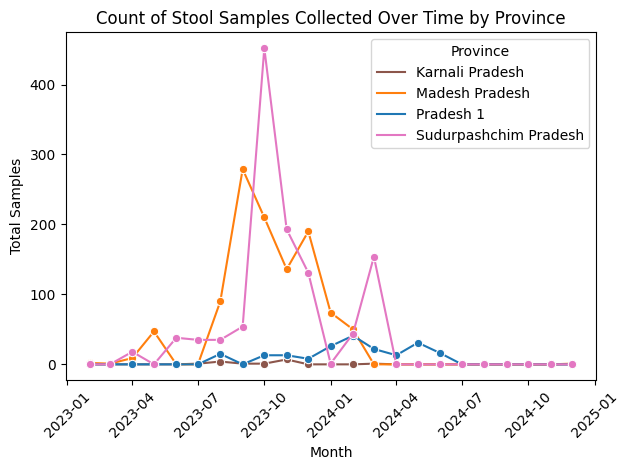

In [53]:
provinces = ["Pradesh 1", "Madesh Pradesh", "Bagmati Pradesh", "Lumbini Pradesh", "Gandaki Pradesh", "Karnali Pradesh", "Sudurpashchim Pradesh"]
palette = sns.color_palette('tab10', len(provinces))
color_mapping = dict(zip(provinces, palette))
# Plotting
plt.figure()
sns.lineplot(data=df_complete, x='month', y='total_samples', hue='province', marker='o', palette=color_mapping)
plt.xticks(rotation=45)
plt.title(f'Count of {sample.capitalize()} Samples Collected Over Time by Province')
plt.xlabel('Month')
plt.ylabel('Total Samples')
plt.legend(title='Province')
plt.tight_layout()
plt.show()


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

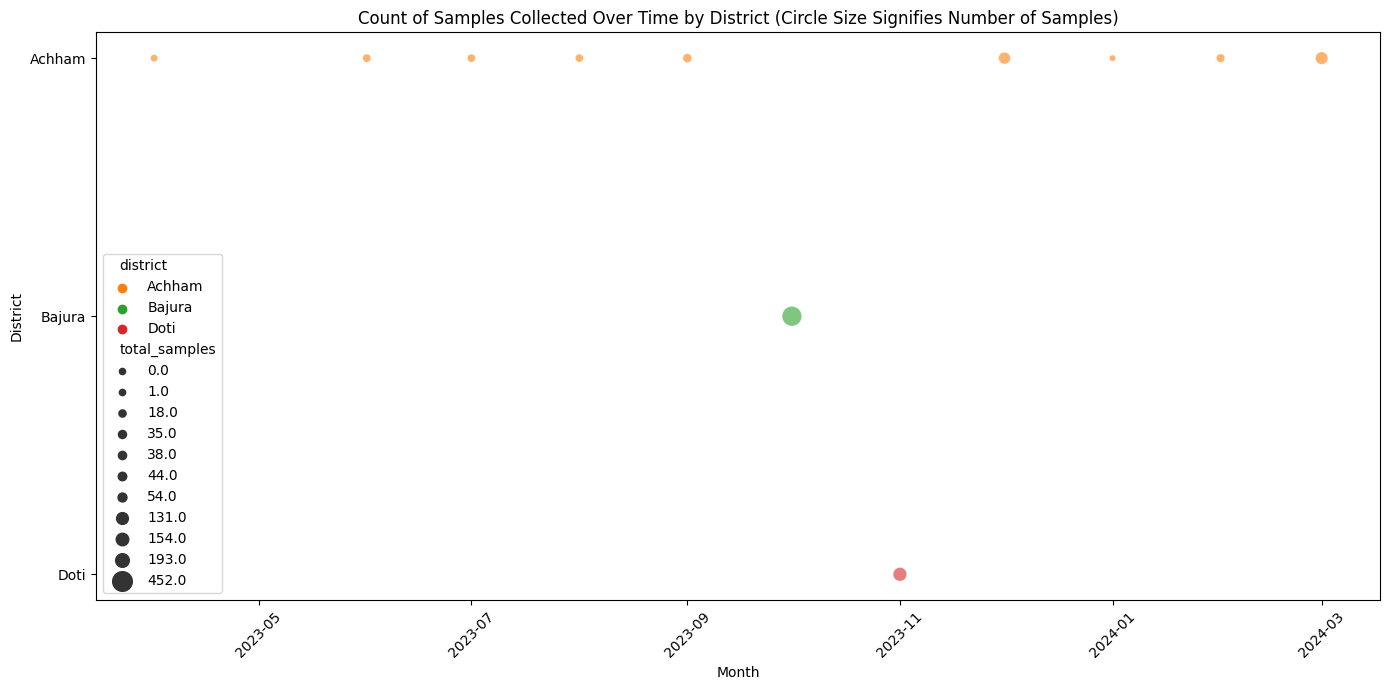

In [63]:
provinces = df_complete[df_complete['province'] == 'Sudurpashchim Pradesh']['district'].unique()
palette = sns.color_palette('tab10', len(provinces))
color_mapping = dict(zip(provinces, palette))
# Plotting
# Plotting
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_complete[df_complete['province'] == 'Sudurpashchim Pradesh'], x='month', y='district', size='total_samples', hue='district', palette=color_mapping, sizes=(20, 200), legend='full', alpha=0.6)
plt.xticks(rotation=45)
plt.title('Count of Samples Collected Over Time by District (Circle Size Signifies Number of Samples)')
plt.xlabel('Month')
plt.ylabel('District')
# plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Patient Age distribution for stool samples

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.stool_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, stool_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, ss.age, ss.gender, 'stool' AS sample_type
FROM 
    sample_stool ss
JOIN 
    complete_samples cs ON ss.id = cs.stool_sample_id
GROUP BY ss.id
)

SELECT 
    ap.name AS province,
    COUNT(*) AS total_samples,
	avg(age) as avg_age
	
FROM (
    SELECT date_of_collection, site_id, age, gender FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    ap.name
ORDER BY 
    ap.name;
"""

age_dist_df = pd.read_sql(query, conn)
conn.close()
age_dist_df

,province,total_samples,avg_age
0,Karnali Pradesh,15,39.000000
1,Madesh Pradesh,1089,34.200184
2,Pradesh 1,198,3.262626
3,Sudurpashchim Pradesh,1155,36.910823


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

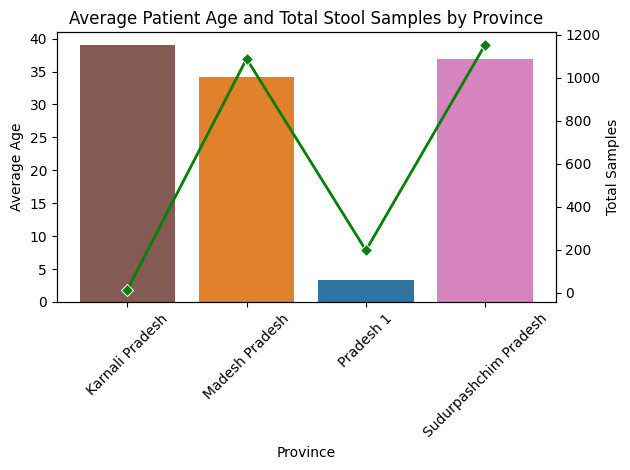

In [88]:
provinces = ["Pradesh 1", "Madesh Pradesh", "Bagmati Pradesh", "Lumbini Pradesh", "Gandaki Pradesh", "Karnali Pradesh", "Sudurpashchim Pradesh"]
palette = sns.color_palette('tab10', len(provinces))
color_mapping = dict(zip(provinces, palette))
# Plotting
fig, ax1 = plt.subplots()

# Bar plot for total samples
sns.barplot(x='province', y='avg_age', data=age_dist_df, ax=ax1, palette=color_mapping)

# Adding the average age as a line plot
ax2 = ax1.twinx()
sns.lineplot(x='province', y='total_samples', data=age_dist_df, ax=ax2, color='green', marker='D', linewidth=2)

# Adding labels and title
ax1.set_xlabel('Province')
ax1.set_ylabel('Average Age')
ax2.set_ylabel('Total Samples')
plt.title('Average Patient Age and Total Stool Samples by Province')

# Rotate x labels for better readability
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.tight_layout()

plt.show()

# Gender distribution for stool sample patients

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.stool_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, stool_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, ss.age, ss.gender, 'stool' AS sample_type
FROM 
    sample_stool ss
JOIN 
    complete_samples cs ON ss.id = cs.stool_sample_id
GROUP BY ss.id
)

SELECT 
    ap.name AS province,
    COUNT(*) AS total_samples,
	gender
FROM (
    SELECT date_of_collection, site_id, age, gender FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    ap.name, gender
ORDER BY 
    ap.name, gender;
"""

gender_dist_df = pd.read_sql(query, conn)
conn.close()

# replace F, M, O by Female, Male, Others
gender_dist_df['gender'] = gender_dist_df['gender'].replace({'F': 'Female', 'M': 'Male', 'O': 'Others'})
gender_dist_df


,province,total_samples,gender
0,Karnali Pradesh,6,Female
1,Karnali Pradesh,9,Male
2,Madesh Pradesh,369,Female
3,Madesh Pradesh,719,Male
4,Madesh Pradesh,1,Others
5,Pradesh 1,81,Female
6,Pradesh 1,117,Male
7,Sudurpashchim Pradesh,569,Female
8,Sudurpashchim Pradesh,585,Male
9,Sudurpashchim Pradesh,1,Others


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future v

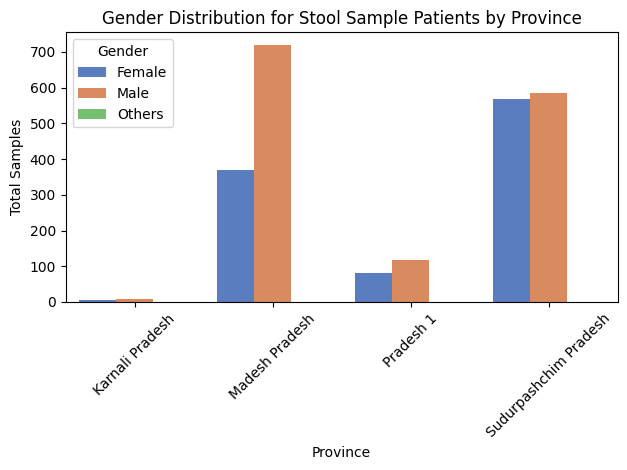

In [105]:
plt.figure()
sns.barplot(x='province', y='total_samples', hue='gender', data=gender_dist_df, palette="muted")

# Adding labels and title
plt.xlabel('Province')
plt.ylabel('Total Samples')
plt.title('Gender Distribution for Stool Sample Patients by Province')

# Rotate x labels for better readability
plt.xticks(rotation=45)
plt.legend(title="Gender", loc='upper left')
plt.tight_layout()

plt.show()

# Water sample types

In [106]:
WATER_TYPE_CHOICES = [
    ("RI", "River"),
    ("BO", "Bottled"),
    ("JA", "Jar"),
    ("LA", "Lake"),
    ("WL", "Wetland"),
    ("WW", "Well Water"),
    ("DB", "Deep Boring"),
    ("PW", "Pond Water"),
    ("ST", "Stream"),
    ("SW", "Spring Water"),
    ("MT", "Tap (Municipal Tap)"),
    ("TA", "Tap (Tanker)"),
    ("TU", "Tap (Tubewell)"),
    ("DH", "Tap (Dhungedhara)"),
    ("BR", "Tap (Boring)"),
    ("FL", "Tap (Filter)"),
    ("WT", "Tap (Water Tank)"),
]

In [107]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.water_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, water_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, ss.type, ss.use, ss.locality, 'water' AS sample_type
FROM 
    sample_water ss
JOIN 
    complete_samples cs ON ss.id = cs.water_sample_id
GROUP BY ss.id
)

SELECT 
    COUNT(*) AS total_samples,
	type
FROM (
    SELECT date_of_collection, site_id, type FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    type
ORDER BY 
    type;
"""

water_type_df = pd.read_sql(query, conn)
conn.close()

# replace types using WATER_TYPE_CHOICES
water_type_df['type'] = water_type_df['type'].replace({k: v for k, v in WATER_TYPE_CHOICES})
water_type_df

,total_samples,type
0,69,Bottled
1,13,Tap (Boring)
2,3,Deep Boring
3,1,Tap (Dhungedhara)
4,3,Tap (Filter)
5,55,Jar
6,1,Lake
7,66,Tap (Municipal Tap)
8,20,Pond Water
9,56,River


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


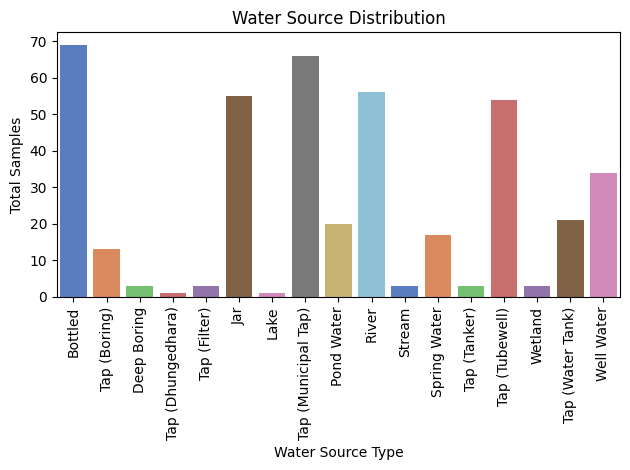

In [110]:
plt.figure()
sns.barplot(x='type', y='total_samples', data=water_type_df, palette="muted")

# Adding labels and title
plt.xlabel('Water Source Type')
plt.ylabel('Total Samples')
plt.title('Water Source Distribution')

# Rotate x labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Water Sample Usage Distribution

In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.water_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, water_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, ss.type, ss.use, ss.locality, 'water' AS sample_type
FROM 
    sample_water ss
JOIN 
    complete_samples cs ON ss.id = cs.water_sample_id
GROUP BY ss.id
)

SELECT 
    COUNT(*) AS total_samples,
	use
FROM (
    SELECT date_of_collection, site_id, use FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    use
ORDER BY 
    use;
"""

water_use_df = pd.read_sql(query, conn)
conn.close()

# replace types using WATER_TYPE_CHOICES
water_use_df

,total_samples,use
0,59,Domestic purpose
1,285,Drinking water
2,3,Fish farming
3,5,Irrigation
4,40,May be irrigation
5,9,May be irrigation and washing vegetables
6,7,Washing clothes and utensils
7,2,Washing clothes and utensils as well as fish f...
8,12,wildlife habitat


In [141]:
# merge May be irrigation and washing vegetables with Irrigation, and make single row
water_use_df.loc[water_use_df['use'] == 'May be irrigation and washing vegetables', 'use'] = 'Irrigation'
water_use_df.loc[water_use_df['use'] == 'May be irrigation', 'use'] = 'Irrigation'
water_use_df.loc[water_use_df['use'] == 'Washing clothes and utensils as well as fish farming', 'use'] = 'Washing clothes and utensils'

In [150]:
water_use_df = water_use_df.groupby(water_use_df['use']).aggregate({'total_samples': 'sum', 'use': 'first'})

/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


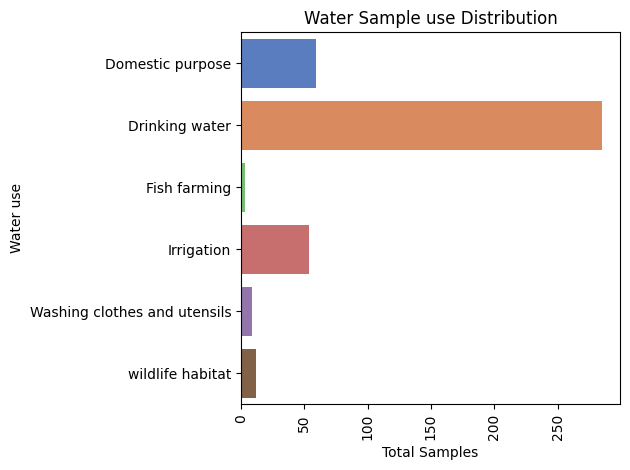

In [151]:
plt.figure()
barplot = sns.barplot(x='total_samples', y='use', data=water_use_df, palette="muted")
# Adding the average age as text labels on top of each bar
# for index, row in water_type_df.iterrows():
#     barplot.text(index, row.use, f'{row.total_samples:.1f}', color='black', ha="center")
# Adding labels and title
plt.xlabel('Total Samples')
plt.ylabel('Water use')
plt.title('Water Sample use Distribution')

# Rotate x labels for better readability
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Vegetable distribution

In [152]:
VEGETABLE_CHOICES = [
    ("CU", "Cucumber"),
    ("CA", "Cabbage"),
    ("TO", "Tomato"),
    ("RA", "Radish"),
    ("CR", "Carrot"),
    ("SP", "Spinach"),
    ("CH", "Chilli"),
]

In [156]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('/home/safal/raavan/parasite/db.sqlite3')

# Query to get sample counts over time by province
sample = "stool"
query = f"""
WITH sample_slide_counts AS (
    SELECT 
        ss.id AS sample_id, ss.vegetable_sample_id, 
        COUNT(sli.id) AS total_images,
        SUM(CASE WHEN sli.image IS NOT "" THEN 1 ELSE 0 END) AS uploaded_images
    FROM 
        sample_slide ss
    LEFT JOIN 
        sample_slideimage sli ON ss.id = sli.slide_id
    GROUP BY 
        ss.id
),
complete_samples AS (
    SELECT 
        sample_id, vegetable_sample_id
    FROM 
        sample_slide_counts
    WHERE 
        total_images = uploaded_images
),

uploaded_samples as (
    SELECT 
    ss.id, ss.date_of_collection, ss.sample_id, ss.site_id, ss.user_id, ss.name as vegetable_name, 'vegetable' AS sample_type
FROM 
    sample_vegetable ss
JOIN 
    complete_samples cs ON ss.id = cs.vegetable_sample_id
GROUP BY ss.id
)

SELECT 
    COUNT(*) AS total_samples,
	vegetable_name
FROM (
    SELECT date_of_collection, site_id, vegetable_name FROM uploaded_samples
) AS s
JOIN address_municipality am ON s.site_id = am.id
JOIN address_district ad ON am.district_id = ad.id
JOIN address_province ap ON ad.province_id = ap.id
GROUP BY 
    vegetable_name
ORDER BY 
    vegetable_name;
"""

vegetable_df = pd.read_sql(query, conn)
conn.close()

# replace types using WATER_TYPE_CHOICES
vegetable_df

,total_samples,vegetable_name
0,125,CA
1,125,CH
2,99,CR
3,124,CU
4,113,RA
5,59,SP
6,129,TO


In [157]:
vegetable_df['vegetable_name'] = vegetable_df['vegetable_name'].replace({k: v for k, v in VEGETABLE_CHOICES})
vegetable_df

,total_samples,vegetable_name
0,125,Cabbage
1,125,Chilli
2,99,Carrot
3,124,Cucumber
4,113,Radish
5,59,Spinach
6,129,Tomato


/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib/python3.12/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


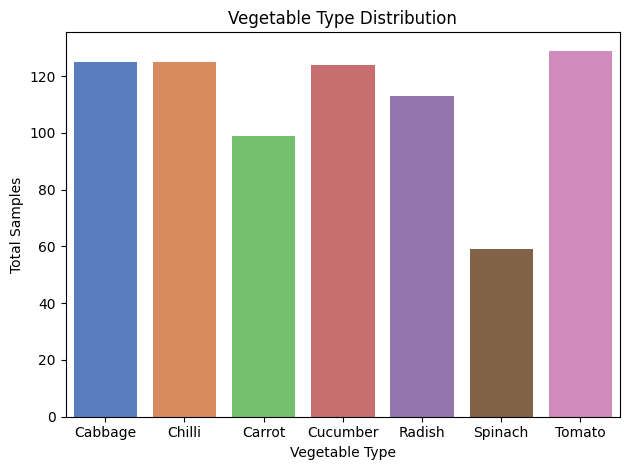

In [160]:
plt.figure()
sns.barplot(x='vegetable_name', y='total_samples', data=vegetable_df, palette="muted")

# Adding labels and title
plt.xlabel('Vegetable Type')
plt.ylabel('Total Samples')
plt.title('Vegetable Type Distribution')

# Rotate x labels for better readability
# plt.xticks(rotation=90)
plt.tight_layout()

plt.show()